<a href="https://colab.research.google.com/github/arjan-hada/protein-design-vae/blob/main/00_msa_for_modelling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Building Multiple Sequence Alignment for Generative modeling

This notebook focuses on constructing high-quality multiple sequence alignments (MSAs) specifically tailored for generative modeling, such as Variational Autoencoders (VAEs) in protein design.

**Goals**
- Performs a BLAST search for query protein sequence
- Retrieve full length homologous protein sequences using ENTREZ
- Filter protein sequences to remove duplicates, non-standard aminoacids
- Sequence alignment, visualization, and alignment quality control

## Setup

In [ ]:
#Install biopython
!pip install biopython &> /dev/null

In [ ]:
#Importing biopython and os
import os
import sys
import Bio

In [ ]:
!apt-get install -qq -y mafft cd-hit &> /dev/null

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context(context="paper", font_scale=1.5)

from slugify import slugify

## Sequence Retrieval



### 1. Retrieve query protein sequence FASTA file

In [ ]:
!mkdir -p data/

In [ ]:
import requests
from Bio import SeqIO, Entrez
from io import StringIO

def download_protein_seq(protein_id, output_dir="data"):

    query_url =  f"https://rest.uniprot.org/uniprotkb/{protein_id}.fasta"
    # Download the FASTA file content from the web link
    response = requests.get(query_url)

    if response.status_code == 200:

        # File path for saving the FASTA file
        output_fpath = f"{output_dir}/{protein_id}.fasta"

        # Parse the content using Biopython's SeqIO
        fasta_content = StringIO(response.text)
        refseq = next(SeqIO.parse(fasta_content, 'fasta'))

        # Writing the sequence record to a file
        with open(output_fpath, 'w') as refseq_out:
            SeqIO.write(refseq, refseq_out, "fasta")

        return refseq
    else:
        print(f"Failed to retrieve data. HTTP Status Code: {response.status_code}")

In [ ]:
refseq = download_protein_seq("B5LY47")
print(f"Protein Sequence: {refseq.seq}")
print(f"Protein Sequence Length: {len(refseq.seq)}")

Protein Sequence: AACIPLLLGSAPLYAQTSAVQQKLAALEKSSGGRLGVALIDTADNTQVLYRGDERFPMCSTSKVMAAAAVLKQSETQKQLLNQPVEIKPADLVNYNPIAEKHVNGTMTLAELSAAALQYSDNTAMNKLIAQLGGPGGVTAFARAIGDETFRLDRTEPTLNTAIPGDPRDTTTPRAMAQTLRQLTLGHALGETQRAQLVTWLKGNTTGAASIRAGLPTSWTVGDKTGSGGYGTTNDIAVIWPQGRAPLVLVTYFTQPQQNAESRRDVLASAARIIAEGL
Protein Sequence Length: 278


In [ ]:
refseqkey = slugify(refseq.id, lowercase=False)
refseqkey

'tr-B5LY47-B5LY47-ECOLX'

In [ ]:
refseq

SeqRecord(seq=Seq('AACIPLLLGSAPLYAQTSAVQQKLAALEKSSGGRLGVALIDTADNTQVLYRGDE...EGL'), id='tr|B5LY47|B5LY47_ECOLX', name='tr|B5LY47|B5LY47_ECOLX', description='tr|B5LY47|B5LY47_ECOLX Beta-lactamase (Fragment) OS=Escherichia coli OX=562 PE=1 SV=1', dbxrefs=[])

### 2. Perform a BLAST search via biopython through NCBIWWW.


In [ ]:
#Using biopython to perform a blast search
%%time
from Bio.Blast import NCBIWWW
#NCBIWWW.qblast(program, database, sequence)

db = 'nr'
hits = 10000
result_handle = NCBIWWW.qblast("blastp", db, refseq.seq, expect=10, #default expect 10
                               hitlist_size=hits)

# Save the BLAST results to a file
fname_nr = f'data/{refseqkey}_blast_{db}_{hits}.xml'
# Open the saved BLAST results file for reading
with open(fname_nr, 'w') as blast_output:
    blast_output.write(result_handle.read())

# Close the result handle
result_handle.close()

CPU times: user 1.92 s, sys: 533 ms, total: 2.46 s
Wall time: 5min 19s


The `expect` parameter sets the E-value threshold for hits. It is a statistical measure that describes the number of hits one can "expect" to see by chance when searching a database of a given size.

### 3. Parse the BLAST results we've obtained from the NCBI BLAST search using NCBIXML

In [ ]:
# Read the results in XML format for parsing BLAST records
from Bio.Blast import NCBIXML
# Open the saved BLAST results file for reading
with open(fname_nr, 'r') as result_file:
    blast_record = NCBIXML.read(result_file)

# access the blast_record for analysis
for alignment in blast_record.alignments[-2:]:
    for hsp in alignment.hsps:
        coverage = 100*sum(c.isalpha() for c in hsp.query)/len(refseq) #sequence coverage relative to the length of the sequence
        PIDcut = 100*hsp.identities/hsp.align_length #sequence identity relative to the length of the alignment
        bit_score_per_residue = hsp.bits / hsp.align_length
        if bit_score_per_residue >= 0.5:
            print()
            print('****Alignment****')
            print(f'Sequence: {alignment.title}')
            print(f'Alignment length: {alignment.length}')
            print(f"Bitscore: {hsp.bits}")
            print(f"Bitscore: {bit_score_per_residue} bit per residue")
            print(f"E-value: {hsp.expect}")
            print("query:", hsp.query[0:75] + "...")
            print("      ", hsp.match[0:75] + "...")
            print("sbjct:", hsp.sbjct[0:75] + "...")

NCBIXML: Ignored: '\nCREATE_VIEW\n\n\n'
NCBIXML: Ignored: '\nCREATE_VIEW\n\n\n'
NCBIXML: Ignored: '\nCREATE_VIEW\n\n\n'
NCBIXML: Ignored: '\nCREATE_VIEW\n\n\n'

****Alignment****
Sequence: ref|WP_233040815.1| class A beta-lactamase [Nocardia yamanashiensis] >gb|UGT44871.1| class A beta-lactamase [Nocardia yamanashiensis]
Alignment length: 312
Bitscore: 237.654
Bitscore: 0.9105517241379311 bit per residue
E-value: 4.58167e-73
query: AACIPLLLGSAPLYAQTSAVQQKLAALEKSSGGRLGVALIDTADNTQVLYRGDERFPMCSTSKVMAAAAVLKQSE...
       AAC     G+ P  +   A     A LE   G RLGV  IDT +   V YR  ERFPM ST K +A  A+L +  ...
sbjct: AACGTDSGGTTPTTSANPAATTAFADLESKHGARLGVYAIDTGNGRTVGYREGERFPMASTFKGLACGALLDEHP...

****Alignment****
Sequence: gb|EJL87933.1| beta-lactamase class A [Herbaspirillum sp. CF444]
Alignment length: 300
Bitscore: 236.884
Bitscore: 0.9006996197718631 bit per residue
E-value: 4.58298e-73
query: TSAVQQKLAALEKSSGGRLGVALIDTADNTQVLYRGDERFPMCSTSKVMAAAAVLKQSETQKQLLNQPVEIKPAD...
       +S+V  +LA LE S GGRLG

In [ ]:
len(blast_record.alignments)

10000

In [ ]:
# How many alignments are above a certain threshold?
len([alignment for alignment in blast_record.alignments for hsp in alignment.hsps if (hsp.bits / hsp.align_length) >= 0.5])

10001

`NCBIXML.read()` is used for parsing BLAST results from a single query, while `NCBIXML.parse()` should be used if the results contain multiple queries.

### 4. Filter and fetch full-length sequences based on specific criteria from blast output

In [ ]:
def fetch_seqs(xmlfile_path, outfile_path, email, bits_per_residue_threshold=None):
    """
    Fetch full-length sequences for hits in a BLAST XML results file, optionally filtering by a bits per residue threshold.

    Parameters:
    - xmlfile_path: Path to the BLAST XML results file.
    - outfile_path: Path to save the fetched sequences (FASTA format).
    - email: Your email, required by NCBI Entrez.
    - bits_per_residue_threshold: Minimum bits per residue value to include a hit, or None for no filtering based on bits per residue.
    """
    # Set up email for Entrez
    Entrez.email = email

    # Open and parse the BLAST XML results file
    with open(xmlfile_path) as xml_file:
        blast_record = NCBIXML.read(xml_file)

    # Open the output file for writing the sequences
    with open(outfile_path, "w") as outfile:
        for alignment in blast_record.alignments:
            for hsp in alignment.hsps:
                if not alignment.hit_id:
                    continue  # Skip this hit if it has no hit ID
                # If bits_per_residue_threshold is specified, calculate bits per residue and check against the threshold
                if bits_per_residue_threshold is not None:
                    bits_per_residue = hsp.bits / hsp.align_length
                    if bits_per_residue < bits_per_residue_threshold:
                        continue  # Skip this hit if it does not meet the threshold

                # Fetch and write sequence if it meets criteria or if no bits_per_residue threshold is specified
                print(f"Fetching protein sequence: {alignment.hit_id} with {bits_per_residue} bits_per_residue")
                try:
                    with Entrez.efetch(db="protein", id=alignment.hit_id, rettype="fasta") as fetch:
                        seq_record = SeqIO.read(fetch, "fasta")
                        SeqIO.write(seq_record, outfile, "fasta")
                except Exception as e:
                    print(f"Error fetching sequence {alignment.hit_id}: {e}")

    print(f"Filtered sequences saved to {outfile_path}")

In [ ]:
fname_nr_fasta = f'data/{refseqkey}_blast_{db}_{hits}.fasta'
fname_nr_fasta

'data/tr-B5LY47-B5LY47-ECOLX_blast_nr_10000.fasta'

In [ ]:
email = "h****@gmail.com"
bits_per_residue_threshold = 0.5
fetch_seqs(fname_nr, fname_nr_fasta, email, bits_per_residue_threshold)

In [ ]:
!grep -c "^>" $fname_nr_fasta

10001


In [ ]:
!head -n 10 $fname_nr_fasta

>QGJ84174.1 CTX-M family beta-lactamase, partial [Escherichia coli]
EMVTKRVQRMMFAAAACIPLLLGSAPLYAQTSAVQQKLAALEKSSGGRLGVALIDTADNT
QVLYRGDERFPMCSTSKVMAAAAVLKQSETQKQLLNQPVEIKPADLVNYNPIAEKHVNGT
MTLAELSAAALQYSDNTAMNKLIAQLGGPGGVTAFARAIGDETFRLDRTEPTLNTAIPGD
PRDTTTPRAMAQTLRQLTLGHALGETQRAQLVTWLKGNTTGAASIRAGLPTSWTVGDKTG
SGGYGTTNDIAVIWPQGRAPLVLVTYFTQPQQNAESRRDVLASAARIIAEGL
>HAW6211090.1 TPA: CTX-M family class A extended-spectrum beta-lactamase [Escherichia coli]
MVTKRVQRMMFAAAACIPLLLGSAPLYAQTSAVQQKLAALEKSSGGRLGVALIDTADNTQ
VLYRGDERFPMCSTSKVMAAAAVLKQSETQKQLLNQPVEIKPADLVNYNPIAEKHVNGTM
TLAELSAAALQYSDNTAMNKLIAQLGGPGGVTAFARAIGDETFRLDRTEPTLNTAIPGDP


In [ ]:
!cat data/B5LY47.fasta $fname_nr_fasta > temp_file.fasta && mv temp_file.fasta $fname_nr_fasta

In [ ]:
!head -n 10 $fname_nr_fasta

>tr|B5LY47|B5LY47_ECOLX Beta-lactamase (Fragment) OS=Escherichia coli OX=562 PE=1 SV=1
AACIPLLLGSAPLYAQTSAVQQKLAALEKSSGGRLGVALIDTADNTQVLYRGDERFPMCS
TSKVMAAAAVLKQSETQKQLLNQPVEIKPADLVNYNPIAEKHVNGTMTLAELSAAALQYS
DNTAMNKLIAQLGGPGGVTAFARAIGDETFRLDRTEPTLNTAIPGDPRDTTTPRAMAQTL
RQLTLGHALGETQRAQLVTWLKGNTTGAASIRAGLPTSWTVGDKTGSGGYGTTNDIAVIW
PQGRAPLVLVTYFTQPQQNAESRRDVLASAARIIAEGL
>QGJ84174.1 CTX-M family beta-lactamase, partial [Escherichia coli]
EMVTKRVQRMMFAAAACIPLLLGSAPLYAQTSAVQQKLAALEKSSGGRLGVALIDTADNT
QVLYRGDERFPMCSTSKVMAAAAVLKQSETQKQLLNQPVEIKPADLVNYNPIAEKHVNGT
MTLAELSAAALQYSDNTAMNKLIAQLGGPGGVTAFARAIGDETFRLDRTEPTLNTAIPGD


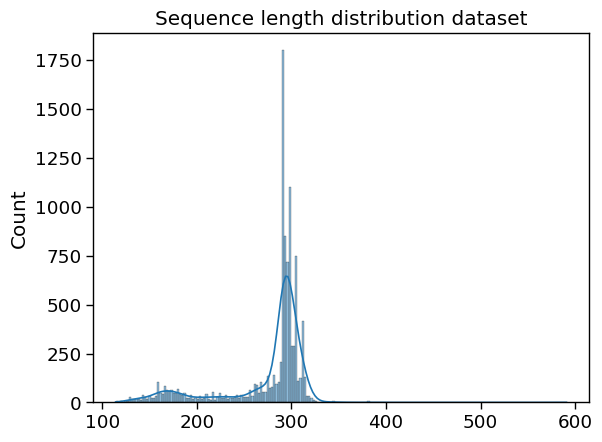

In [ ]:
seq_lens = [len(record.seq) for record in SeqIO.parse(fname_nr_fasta, "fasta")]
sns.histplot(seq_lens, kde=True)
plt.title("Sequence length distribution dataset");

## Redundancy Reduction and Quality Filtering

### 1. Remove duplicate sequences (optional)

We will use **CD-HIT** for redundancy reduction. CD-HIT efficiently removes nearly identical sequences from large datasets, keeping only representative sequences for each cluster. This process significantly reduces the size of the dataset without losing significant biological information. This might be beneficial for phylogenetic analysis. However, for training neural networks duplicates or near-duplicates can be useful for data augmentation.

In [ ]:
fname_nr_for_cdhit = f'data/{refseqkey}_blast_{db}_{hits}_for_cdhit.fasta'
fname_nr_for_cdhit

'data/tr-B5LY47-B5LY47-ECOLX_blast_nr_10000_for_cdhit.fasta'

In [ ]:
fname_nr_nodup = f'data/{refseqkey}_blast_{db}_{hits}_nodup.fasta'
fname_nr_nodup

'data/tr-B5LY47-B5LY47-ECOLX_blast_nr_10000_nodup.fasta'

In [ ]:
#cd-hit only reads ungapped, single-line fasta
from Bio.Seq import Seq
from Bio import SeqIO
with open(fname_nr_for_cdhit, "w") as o:
    for record in SeqIO.parse(fname_nr_fasta, "fasta"):
        #record.seq = record.seq.ungap("-")
        SeqIO.write(record, o, "fasta-2line")

#Now we use cd-hit
!cd-hit -i $fname_nr_for_cdhit -o $fname_nr_nodup -c 1.0

Program: CD-HIT, V4.8.1 (+OpenMP), Aug 20 2021, 08:39:56
Command: cd-hit -i
         data/tr-B5LY47-B5LY47-ECOLX_blast_nr_10000_for_cdhit.fasta
         -o
         data/tr-B5LY47-B5LY47-ECOLX_blast_nr_10000_nodup.fasta
         -c 1.0

Started: Mon Mar 25 17:30:11 2024
                            Output                              
----------------------------------------------------------------
total seq: 10002
longest and shortest : 591 and 114
Total letters: 2744255
Sequences have been sorted

Approximated minimal memory consumption:
Sequence        : 4M
Buffer          : 1 X 10M = 10M
Table           : 1 X 65M = 65M
Miscellaneous   : 0M
Total           : 80M

Table limit with the given memory limit:
Max number of representatives: 1828304
Max number of word counting entries: 89950546

comparing sequences from          0  to      10002
..........    10000  finished       7790  clusters

    10002  finished       7790  clusters

Approximated maximum memory consumption: 98M
writing n

**Parameters Explained**

- **"FASTA-2line"** (or "FASTA two-line") refers to a variation of the FASTA format where each sequence in the file is represented by exactly two lines: the first line is the header (starting with ">"), and the second line is the sequence data. This format simplifies parsing and handling of sequences because each sequence entry occupies exactly two lines, making it straightforward to read and process with scripts or programs.

- Note that we are using `-c 1.0`, where 1.0 refers to 100% PID, to only eliminate duplicates.

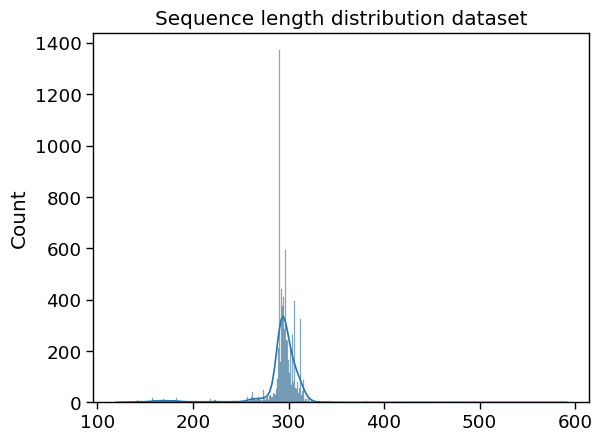

In [ ]:
seq_lens = [len(record.seq) for record in SeqIO.parse(fname_nr_nodup, "fasta")]
sns.histplot(seq_lens, kde=True)
plt.title("Sequence length distribution dataset");

### 2. Replacing "X" with gaps ("-"), remove sequences with non-standard amino acids, and filter out sequences that are shorter than a specified minimum length or longer than a specified maximum length.

In [ ]:
from Bio import SeqIO
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord

def is_std_aa(seq):
    """Check if the sequence contains only standard amino acids or gaps."""
    for aa in seq:
        if aa not in '-ACDEFGHIKLMNPQRSTVWY':
            return False
    return True

def preprocess_fasta(infile, outfile, min_len=None, max_len=None):
    """
    Cleans and filters a FASTA file by replacing 'X' with gaps ('-'), removing sequences
    with non-standard amino acids, and excluding sequences outside the specified length range
    if provided.

    Parameters:
    - infile: Path to the input FASTA file.
    - outfile: Path to the output FASTA file after processing.
    - min_len: Minimum length required for a sequence to be included (optional).
    - max_len: Maximum length allowed for a sequence to be included (optional).
    """

    with open(infile, "r") as infile, open(outfile, "w") as outfile:
        for record in SeqIO.parse(infile, "fasta"):
            # Skip sequences with non-standard amino acids
            if not is_std_aa(str(record.seq)):
                continue
            # Filter sequences by length if min_length or max_length is specified
            if min_len is not None and len(str(record.seq)) <= min_len:
                continue
            if max_len is not None and len(str(record.seq)) >= max_len:
                continue
            # Create a new SeqRecord with the modified sequence
            modified_record = SeqRecord(Seq(str(record.seq)),
                                        id=record.id,
                                        name=record.name,
                                        description=record.description)
            # Write the modified record to the output file
            SeqIO.write(modified_record, outfile, "fasta")

In [ ]:
fname_nr_qc = f'data/{refseqkey}_blast_{db}_{hits}_qc.fasta'
fname_nr_qc

'data/tr-B5LY47-B5LY47-ECOLX_blast_nr_10000_qc.fasta'

In [ ]:
# Proceeding without CD-HIT
preprocess_fasta(fname_nr_fasta, fname_nr_qc, min_len=250, max_len=300)

In [ ]:
!grep -c "^>" $fname_nr_qc

5835


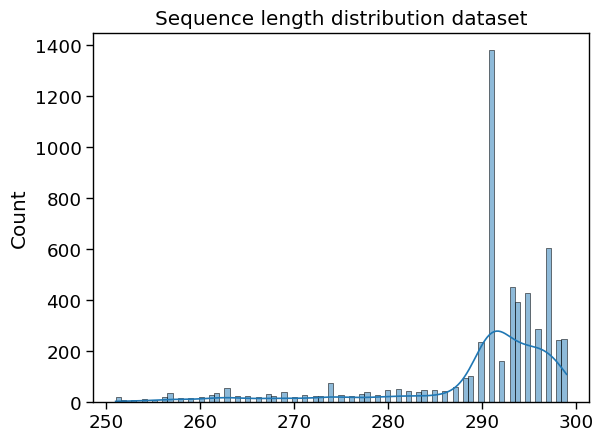

In [ ]:
seq_lens = [len(record.seq) for record in SeqIO.parse(fname_nr_qc, "fasta")]
sns.histplot(seq_lens, kde=True)
plt.title("Sequence length distribution dataset");

## Sequence alignment, visualization, and alignment quality control

### 1. Align sequences using MAFFT

In [ ]:
import subprocess
from Bio import AlignIO
from io import StringIO

def align_seqs_mafft(infile_path, outfile_path=None, mafft_path='mafft'):
    """
    Align sequences using MAFFT and return the alignment object. Optionally save the alignment to a file.

    Parameters:
    - infile_path: Path to the input file containing sequences to align (FASTA format).
    - outfile_path: Path to save the aligned sequences (FASTA format). If None, the alignment is not saved to a file.
    - mafft_path: Path to the MAFFT executable. Default assumes 'mafft' is in the system's PATH.

    Returns:
    - A Bio.Align.MultipleSeqAlignment object containing the alignment.
    """
    command = [mafft_path, '--auto', infile_path]

    try:
        result = subprocess.run(command, capture_output=True, text=True, check=True)
        # Parse the alignment directly from result.stdout
        alignment = AlignIO.read(StringIO(result.stdout), "fasta")

        # Optionally, save the alignment to a file
        if outfile_path:
            with open(outfile_path, "w") as aligned_file:
                AlignIO.write(alignment, aligned_file, "fasta")

        return alignment
    except subprocess.CalledProcessError as e:
        print(f"Error executing MAFFT: {e.stderr}")
        return None

In [ ]:
fname_nr_aligned = f'data/{refseqkey}_blast_{db}_{hits}_aligned.fasta'
fname_nr_aligned

'data/tr-B5LY47-B5LY47-ECOLX_blast_nr_10000_aligned.fasta'

In [ ]:
alignment = align_seqs_mafft(fname_nr_qc, fname_nr_aligned)
if alignment:
    print("Alignment successful.")
else:
    print("Alignment failed.")

Alignment successful.


In [ ]:
# length of alignment
len(alignment[0].seq)

773

In [ ]:
import numpy as np
from matplotlib.colors import ListedColormap, BoundaryNorm

def plot_msa(fasta_file, fig_ht= 10, max_sequences=100):
    """
    Visualizes a subset of a Multiple Sequence Alignment from a FASTA file using a specified color scheme.
    Limited to displaying a maximum of 'max_sequences' to avoid large image sizes.

    Parameters:
    - fasta_file (str): Path to the FASTA file containing the MSA.
    - fig_ht (int): Height of the figure in inches.
    - max_sequences (int): Maximum number of sequences to display.
    """
    alignment = AlignIO.read(fasta_file, "fasta")
    sequences = [str(record.seq) for record in alignment][:max_sequences]  # Display only a subset

    # Your color mapping here
    clrs = {'K': 'red', 'R': 'red', 'H': 'red', 'D': 'green', 'E': 'green',
            'Q': 'blue', 'N': 'blue', 'S': 'blue', 'T': 'blue', 'A': 'blue',
            'I': 'blue', 'L': 'blue', 'M': 'blue', 'V': 'blue', 'F': 'orange',
            'Y': 'orange', 'W': 'orange', 'C': 'blue', 'P': 'yellow', 'G': 'orange', '-': 'white'}

    # Map each amino acid to an integer
    aa_to_int = {aa: i for i, aa in enumerate(clrs.keys())}
    int_to_color = list(clrs.values())

    # Convert sequences to a numeric array
    msa_numeric = np.array([[aa_to_int[aa] for aa in seq] for seq in sequences])

    # Create a colormap
    cmap = ListedColormap(int_to_color)
    norm = BoundaryNorm(np.arange(-0.5, len(clrs) + 0.5, 1), cmap.N)

    #fig, ax = plt.subplots(figsize=(12, len(sequences) / 4), dpi=80)  # Adjusted for fewer sequences and manageable image size
    fig, ax = plt.subplots(figsize=(12, fig_ht), dpi=80)
    cax = ax.imshow(msa_numeric, aspect='auto', cmap=cmap, norm=norm, interpolation='none')

    ax.set_xlabel('Position in Alignment')
    ax.set_ylabel('Sequence Index')
    ax.set_title('Multiple Sequence Alignment Visualization')
    ax.grid(False)

    # Add a colorbar with custom mapping
    cbar = fig.colorbar(cax, ticks=np.arange(len(clrs)), fraction=0.046, pad=0.04)
    cbar.ax.set_yticklabels(clrs.keys())

    plt.tight_layout()
    plt.show()

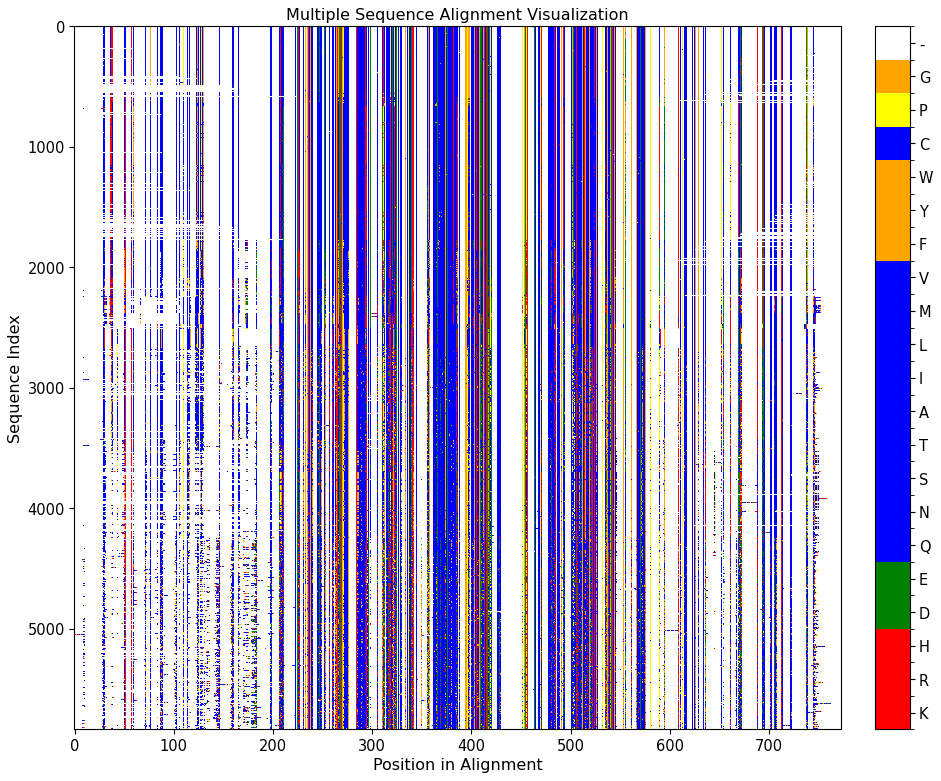

In [ ]:
plot_msa(fname_nr_aligned, fig_ht=10, max_sequences=-1)

### 2. Identify and remove sequences from a MSA that contribute excessively to gaps.

The ultimate aim is to ensure the alignment is as clean and informative as possible, removing sequences that disrupt the overall alignment without losing essential data. This makes subsequent analyses more straightforward and potentially more accurate.

In [ ]:
import numpy as np
from Bio import AlignIO

def remove_high_gap_sequences(infile_path, outfile_path, threshold=0.95,
                              min_contribution=10):
    """
    The function processes the input alignment by identifying and removing sequences that introduce excessive gaps
    (based on the 'threshold' and 'min_contribution' parameters). It then removes all gap characters from the
    remaining sequences, creating an ungapped sequence dataset ready for realignment. The filtered and ungapped
    sequences are saved to 'output_path', suitable for subsequent alignment procedures, such as MAFFT.

    Parameters:
        infile_path (str): Path to the input FASTA file containing the original aligned sequences.
        outfile_path (str): Path to the output FASTA file for the filtered and ungapped sequences.
        threshold (float): The threshold for determining high-gap columns. A column is considered high-gap if
                           the percentage of gap characters exceeds this threshold.
        min_contribution (int): The maximum allowed contributions of non-gap characters to high-gap columns
                                by a sequence. Sequences exceeding this contribution are filtered out.
    """

    # Load the alignment
    alignment = AlignIO.read(infile_path, "fasta")

    # Convert alignment to a NumPy array
    alignment_array = np.array([list(str(record.seq)) for record in alignment])

    # Calculate gap frequencies for each column
    gap_frequencies = np.mean(alignment_array == '-', axis=0)

    # Identify columns with gap frequencies above the threshold
    high_gap_columns = gap_frequencies > threshold

    # Calculate the contribution of each sequence to high-gap columns
    contributions = np.sum((alignment_array != '-') & high_gap_columns, axis=1)

    # Determine which sequences to keep based on their contributions
    # Ensure the reference sequence is not removed by checking its ID
    sequences_to_keep = [alignment[i] for i in range(len(alignment))
                         if contributions[i] <= min_contribution]

    # Ungap the filtered sequences
    ungapped_sequences = [SeqRecord(seq=Seq(str(record.seq).replace("-", "")), id=record.id, description=record.description)
                          for record in sequences_to_keep]

    # Write the ungapped, filtered sequences to the output FASTA file
    SeqIO.write(ungapped_sequences, outfile_path, "fasta")

**Parameters Explained**

- **`threshold`**: This parameter sets the bar for what counts as a "problematic column." It's the percentage of sequences in a column that must have a gap to consider that column problematic. A higher `threshold` means you're stricter about what counts as problematic. For example, a `threshold` of 0.95 means a column must be 95% gaps to be considered problematic.

- **`min_contribution`**: This parameter determines how much a sequence's contribution to the problematic gaps is too much, leading to its removal. It's the number of problematic spots a sequence can contribute to before being considered disruptive. For instance, a `min_contribution` of 10 means any sequence that contributes non-gap characters to more than 10 of these highly gappy columns is removed.

In [ ]:
fname_nr_aligned_filt_fasta = f'data/{refseqkey}_blast_{db}_{hits}_aligned_filt.fasta'
fname_nr_aligned_filt_fasta

'data/tr-B5LY47-B5LY47-ECOLX_blast_nr_10000_aligned_filt.fasta'

In [ ]:
remove_high_gap_sequences(fname_nr_aligned, fname_nr_aligned_filt_fasta,
                          threshold=0.91, min_contribution=1)

In [ ]:
!grep -c "^>" $fname_nr_aligned_filt_fasta

3029


Check to make sure reference sequence exist. If not add the sequence.

In [ ]:
!head -n 10 $fname_nr_aligned_filt_fasta

>tr|B5LY47|B5LY47_ECOLX Beta-lactamase (Fragment) OS=Escherichia coli OX=562 PE=1 SV=1
AACIPLLLGSAPLYAQTSAVQQKLAALEKSSGGRLGVALIDTADNTQVLYRGDERFPMCS
TSKVMAAAAVLKQSETQKQLLNQPVEIKPADLVNYNPIAEKHVNGTMTLAELSAAALQYS
DNTAMNKLIAQLGGPGGVTAFARAIGDETFRLDRTEPTLNTAIPGDPRDTTTPRAMAQTL
RQLTLGHALGETQRAQLVTWLKGNTTGAASIRAGLPTSWTVGDKTGSGGYGTTNDIAVIW
PQGRAPLVLVTYFTQPQQNAESRRDVLASAARIIAEGL
>QGJ84174.1 CTX-M family beta-lactamase, partial [Escherichia coli]
EMVTKRVQRMMFAAAACIPLLLGSAPLYAQTSAVQQKLAALEKSSGGRLGVALIDTADNT
QVLYRGDERFPMCSTSKVMAAAAVLKQSETQKQLLNQPVEIKPADLVNYNPIAEKHVNGT
MTLAELSAAALQYSDNTAMNKLIAQLGGPGGVTAFARAIGDETFRLDRTEPTLNTAIPGD


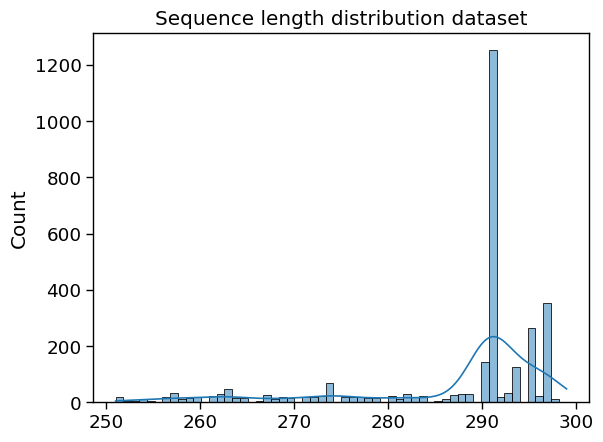

In [ ]:
seq_lens = [len(record.seq) for record in SeqIO.parse(fname_nr_aligned_filt_fasta, "fasta")]
sns.histplot(seq_lens, kde=True)
plt.title("Sequence length distribution dataset");

3. Realign using our filtered sequences and visually inspect it.

In [ ]:
fname_nr_aligned_1 = f'data/{refseqkey}_blast_{db}_{hits}_aligned_1.fasta'
fname_nr_aligned_1

'data/tr-B5LY47-B5LY47-ECOLX_blast_nr_10000_aligned_1.fasta'

In [ ]:
alignment = align_seqs_mafft(fname_nr_aligned_filt_fasta, fname_nr_aligned_1)
if alignment:
    print("Alignment successful.")
else:
    print("Alignment failed.")

Alignment successful.


In [ ]:
# length of alignment
len(alignment[0].seq)

332

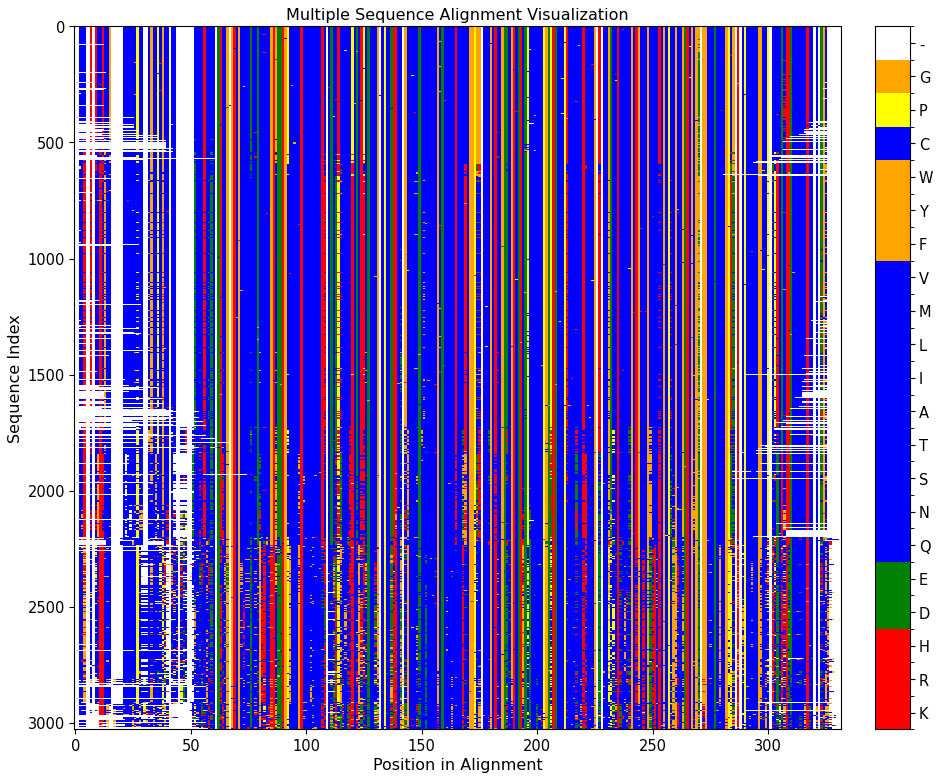

In [ ]:
plot_msa(fname_nr_aligned_1, fig_ht=10, max_sequences=-1)

To train a generative model, we need redundancy-reduced number of sequences ≥ 10L, where L is the sequence length.

## Download files

In [ ]:
# Download final model from colab
!zip -r data/tr-B5LY47-B5LY47-ECOLX_blast_nr_10000.zip data/

  adding: data/ (stored 0%)
  adding: data/.ipynb_checkpoints/ (stored 0%)
  adding: data/tr-B5LY47-B5LY47-ECOLX_blast_nr_10000_qc.fasta (deflated 85%)
  adding: data/tr-B5LY47-B5LY47-ECOLX_blast_nr_10000.xml (deflated 90%)
  adding: data/B5LY47.fasta (deflated 26%)
  adding: data/tr-B5LY47-B5LY47-ECOLX_blast_nr_10000_aligned.fasta (deflated 90%)
  adding: data/tr-B5LY47-B5LY47-ECOLX_blast_nr_10000.fasta (deflated 83%)
  adding: data/tr-B5LY47-B5LY47-ECOLX_blast_nr_10000_aligned_filt.fasta (deflated 91%)
  adding: data/tr-B5LY47-B5LY47-ECOLX_blast_nr_10000_aligned_1.fasta (deflated 92%)


In [ ]:
# Download that zip file
from google.colab import files
files.download("data/tr-B5LY47-B5LY47-ECOLX_blast_nr_10000.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>